In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import pandas as pd
import os

# Ruta de los chunks y processed_data
chunks_path = "/content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/embeddings_chunked_keep"
processed_data_path = "/content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/processed_data_validation.csv"

# Cargar todos los chunks de embeddings
def load_all_chunks(chunks_path, prefix):
    """
    Carga y combina todos los chunks de embeddings guardados.
    Args:
        chunks_path (str): Ruta donde están almacenados los chunks.
        prefix (str): Prefijo común de los archivos de embeddings.
    Returns:
        torch.Tensor: Embeddings combinados.
    """
    embeddings = []
    for i in range(1, 46):  # Ajusta según el número de chunks
        chunk_file = os.path.join(chunks_path, f"{prefix}_chunk_{i}.pt")
        print(f"Cargando {chunk_file}...")
        chunk = torch.load(chunk_file)
        embeddings.append(chunk)
    return torch.cat(embeddings, dim=0)

# Cargar embeddings
embeddings_keep_specials = load_all_chunks(chunks_path, "embeddings_keep_specials_validation")

# Cargar el DataFrame procesado
data_validation = pd.read_csv(processed_data_path)

# Verificar dimensiones
print(f"Dimensiones de los embeddings: {embeddings_keep_specials.shape}")
print(f"Dimensiones del DataFrame: {data_validation.shape}")


Cargando /content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/embeddings_chunked_keep/embeddings_keep_specials_validation_chunk_1.pt...


<ipython-input-2-089e82ba901f>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chunk = torch.load(chunk_file)


Cargando /content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/embeddings_chunked_keep/embeddings_keep_specials_validation_chunk_2.pt...
Cargando /content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/embeddings_chunked_keep/embeddings_keep_specials_validation_chunk_3.pt...
Cargando /content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/embeddings_chunked_keep/embeddings_keep_specials_validation_chunk_4.pt...
Cargando /content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/embeddings_chunked_keep/embeddings_keep_specials_validation_chunk_5.pt...
Cargando /content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/embeddings_chunked_keep/embeddings_keep_specials_validation_chunk_6.pt...
Cargando /content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/embeddings_chunked_keep/embeddings_keep_specials_validation_chunk_7.pt...
Cargando /content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/dat

In [3]:
import joblib
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.models import load_model

# Cargar Logistic Regression
logistic_model = joblib.load("/content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/modelos/logistic_regression_model.pkl")

# Cargar XGBoost
xgboost_model = xgb.Booster()
xgboost_model.load_model("/content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/modelos/xgboost_model.json")

# Cargar LightGBM
lightgbm_model = lgb.Booster(model_file="/content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/modelos/lightgbm_model.txt")

# Cargar Neural Network
neural_network_model = load_model("/content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/modelos/neural_network_model.h5")

print("Modelos cargados correctamente.")


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Modelos cargados correctamente.


In [4]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import xgboost as xgb

# Convertir embeddings a CPU y luego a numpy
X_validation = embeddings_keep_specials.cpu().numpy()

# Predicciones con Logistic Regression
logistic_probs = logistic_model.predict_proba(X_validation)[:, 1]  # Probabilidades clase positiva
logistic_preds = (logistic_probs > 0.5).astype(int)  # Binarizar con umbral 0.5

# Crear DMatrix para los datos de validación
dmatrix_validation = xgb.DMatrix(X_validation)

# Predicciones con XGBoost
xgboost_probs = xgboost_model.predict(dmatrix_validation)  # Probabilidades clase positiva
xgboost_preds = (xgboost_probs > 0.5).astype(int)  # Binarizar con umbral 0.5

# Predicciones con LightGBM
lightgbm_probs = lightgbm_model.predict(X_validation)  # Probabilidades clase positiva
lightgbm_preds = (lightgbm_probs > 0.5).astype(int)  # Binarizar con umbral 0.5

# Predicciones con Neural Network
neural_probs = neural_network_model.predict(X_validation).flatten()  # Probabilidades clase positiva
neural_preds = (neural_probs > 0.5).astype(int)  # Binarizar con umbral 0.5

print("Predicciones realizadas correctamente.")


1403/1403 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Predicciones realizadas correctamente.


In [5]:
data_validation.head()

,text,label,prompt_name,source,RDizzl3_seven,text_clean_specials_removed,text_clean_keep_specials,tokens_specials_removed,tokens_keep_specials
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,phones modern humans today are always on their...,phones modern humans today are always on their...,"['▁phones', '▁modern', '▁humans', '▁today', '▁...","['▁phones', '▁modern', '▁humans', '▁today', '▁..."
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,this essay will explain if drivers should or s...,this essay will explain if drivers should or s...,"['▁this', '▁essay', '▁will', '▁explain', '▁if'...","['▁this', '▁essay', '▁will', '▁explain', '▁if'..."
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,driving while the use of cellular devices toda...,driving while the use of cellular devices toda...,"['▁driving', '▁while', '▁the', '▁use', '▁of', ...","['▁driving', '▁while', '▁the', '▁use', '▁of', ..."
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,phones driving drivers should not be able to u...,phones & driving drivers should not be able to...,"['▁phones', '▁driving', '▁drivers', '▁should',...","['▁phones', '▁&', '▁driving', '▁drivers', '▁sh..."
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,cell phone operation while driving the ability...,cell phone operation while driving the ability...,"['▁cell', '▁phone', '▁operation', '▁while', '▁...","['▁cell', '▁phone', '▁operation', '▁while', '▁..."


In [6]:
# Evaluar cada modelo
def evaluate_model(y_true, preds, probs, model_name):
    """
    Evalúa un modelo con métricas clave.
    Args:
        y_true (array): Etiquetas verdaderas.
        preds (array): Predicciones binarias del modelo.
        probs (array): Probabilidades predichas.
        model_name (str): Nombre del modelo.
    """
    print(f"\nEvaluación para {model_name}:")
    print(f"Exactitud: {accuracy_score(y_true, preds):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, probs):.4f}")
    print("Reporte de Clasificación:")
    print(classification_report(y_true, preds))

# Etiquetas verdaderas
y_true = data_validation['label'].values  # Ajusta si el nombre de la columna es diferente

# Evaluar Logistic Regression
evaluate_model(y_true, logistic_preds, logistic_probs, "Logistic Regression")

# Convertir probabilidades continuas a etiquetas binarias para XGBoost
xgboost_preds_binary = (xgboost_probs > 0.5).astype(int)

# Evaluar XGBoost
evaluate_model(y_true, xgboost_preds_binary, xgboost_probs, "XGBoost")

# Evaluar LightGBM (ajuste del orden de argumentos)
evaluate_model(y_true, lightgbm_preds, lightgbm_probs, "LightGBM")

# Evaluar Neural Network
evaluate_model(y_true, neural_preds, neural_probs, "Neural Network")




Evaluación para Logistic Regression:
Exactitud: 0.9681
AUC-ROC: 0.9955
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     27371
           1       0.93      0.99      0.96     17497

    accuracy                           0.97     44868
   macro avg       0.96      0.97      0.97     44868
weighted avg       0.97      0.97      0.97     44868


Evaluación para XGBoost:
Exactitud: 0.9382
AUC-ROC: 0.9734
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27371
           1       0.89      0.96      0.92     17497

    accuracy                           0.94     44868
   macro avg       0.93      0.94      0.94     44868
weighted avg       0.94      0.94      0.94     44868


Evaluación para LightGBM:
Exactitud: 0.9617
AUC-ROC: 0.9939
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0

In [7]:
# Convertir predicciones continuas de LightGBM a etiquetas binarias
lightgbm_preds_binary = (lightgbm_probs > 0.5).astype(int)  # Usar lightgbm_probs para consistencia

# Crear el resumen de resultados
results = {
    "Modelo": ["Logistic Regression", "XGBoost", "LightGBM", "Neural Network"],
    "Exactitud": [
        accuracy_score(y_true, logistic_preds),
        accuracy_score(y_true, xgboost_preds_binary),  # Predicciones binarias
        accuracy_score(y_true, lightgbm_preds_binary),  # Predicciones binarias
        accuracy_score(y_true, neural_preds)
    ],
    "AUC-ROC": [
        roc_auc_score(y_true, logistic_probs),  # Probabilidades continuas
        roc_auc_score(y_true, xgboost_probs),  # Probabilidades continuas
        roc_auc_score(y_true, lightgbm_probs),  # Probabilidades continuas
        roc_auc_score(y_true, neural_probs)    # Probabilidades continuas
    ]
}

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)
print("\nResumen de Resultados:")
print(results_df)



Resumen de Resultados:
                Modelo  Exactitud   AUC-ROC
0  Logistic Regression   0.968062  0.995534
1              XGBoost   0.938241  0.973387
2             LightGBM   0.961688  0.993947
3       Neural Network   0.979919  0.995803


Generando matrices de confusión con métricas...


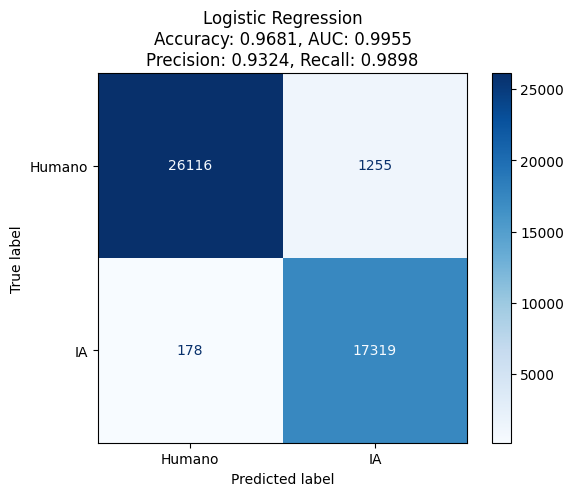

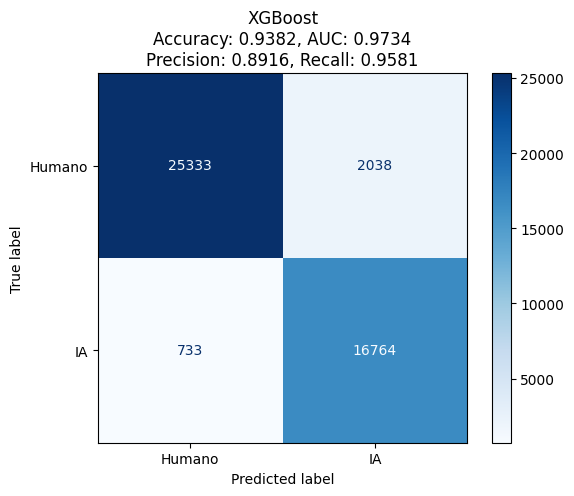

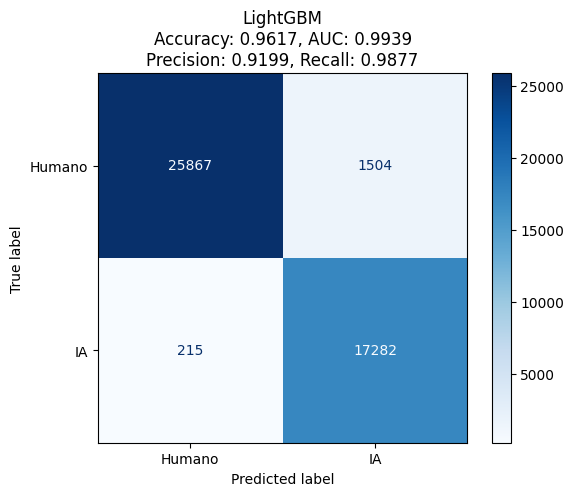

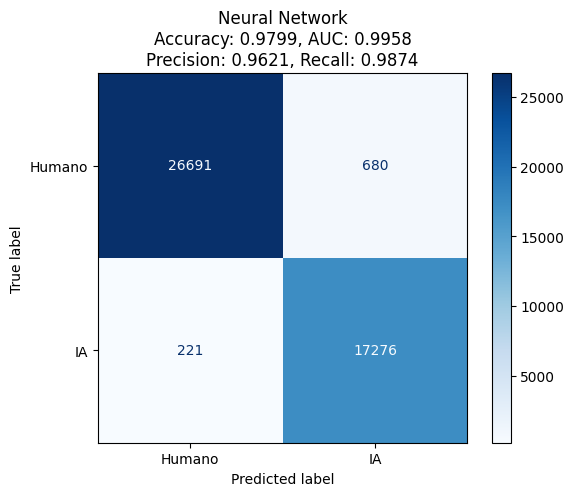

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score

# Función para graficar la matriz de confusión con métricas
def plot_confusion_matrix_with_metrics(y_true, y_pred, probs, model_name, display_labels=None):
    """
    Grafica la matriz de confusión con las métricas de evaluación.
    Args:
        y_true (array): Etiquetas verdaderas.
        y_pred (array): Predicciones del modelo.
        probs (array): Probabilidades predichas del modelo.
        model_name (str): Nombre del modelo.
        display_labels (list): Etiquetas para la matriz de confusión.
    """
    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, probs)

    # Generar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels or [0, 1])
    disp.plot(cmap=plt.cm.Blues)

    # Añadir las métricas al título
    plt.title(
        f"{model_name}\n"
        f"Accuracy: {accuracy:.4f}, AUC: {auc:.4f}\n"
        f"Precision: {precision:.4f}, Recall: {recall:.4f}"
    )
    plt.show()

# Etiquetas personalizadas
labels = ["Humano", "IA"]

# Generar y graficar las matrices de confusión para cada modelo con métricas
print("Generando matrices de confusión con métricas...")

# Logistic Regression
plot_confusion_matrix_with_metrics(y_true, logistic_preds, logistic_probs, "Logistic Regression", display_labels=labels)

# XGBoost
plot_confusion_matrix_with_metrics(y_true, xgboost_preds_binary, xgboost_probs, "XGBoost", display_labels=labels)

# LightGBM
plot_confusion_matrix_with_metrics(y_true, lightgbm_preds_binary, lightgbm_probs, "LightGBM", display_labels=labels)

# Neural Network
plot_confusion_matrix_with_metrics(y_true, neural_preds, neural_probs, "Neural Network", display_labels=labels)




Análisis de Falsos Positivos: Logistic Regression
Frecuencia de 'source':
source
persuade_corpus    1209
train_essays         46
Name: count, dtype: int64

Frecuencia de 'prompt_name':
prompt_name
Distance learning                        209
Summer projects                          160
Community service                        127
Grades for extracurricular activities     99
Exploring Venus                           92
Car-free cities                           81
Phones and driving                        76
Mandatory extracurricular activities      73
Does the electoral college work?          67
Cell phones at school                     67
Facial action coding system               53
Driverless cars                           47
Seeking multiple opinions                 42
"A Cowboy Who Rode the Waves"             31
The Face on Mars                          31
Name: count, dtype: int64


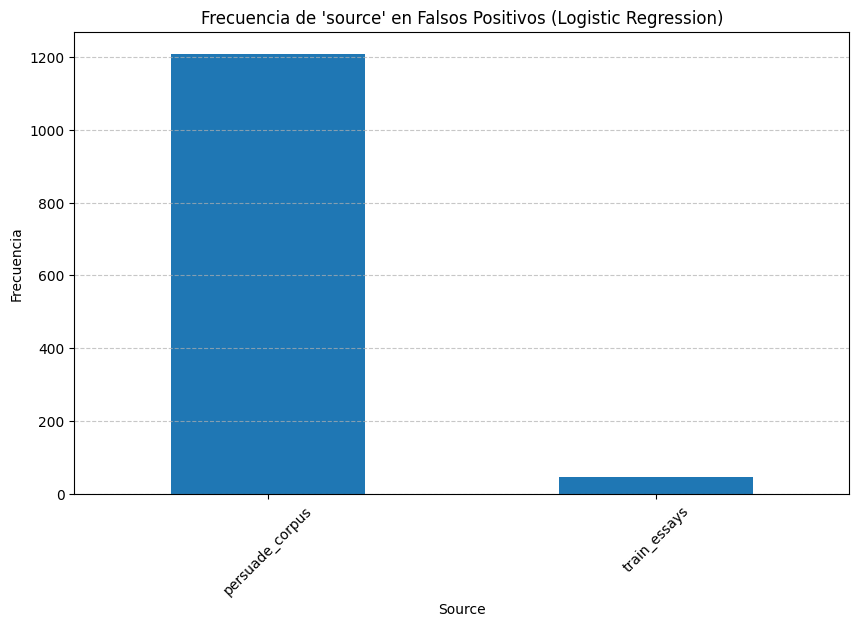

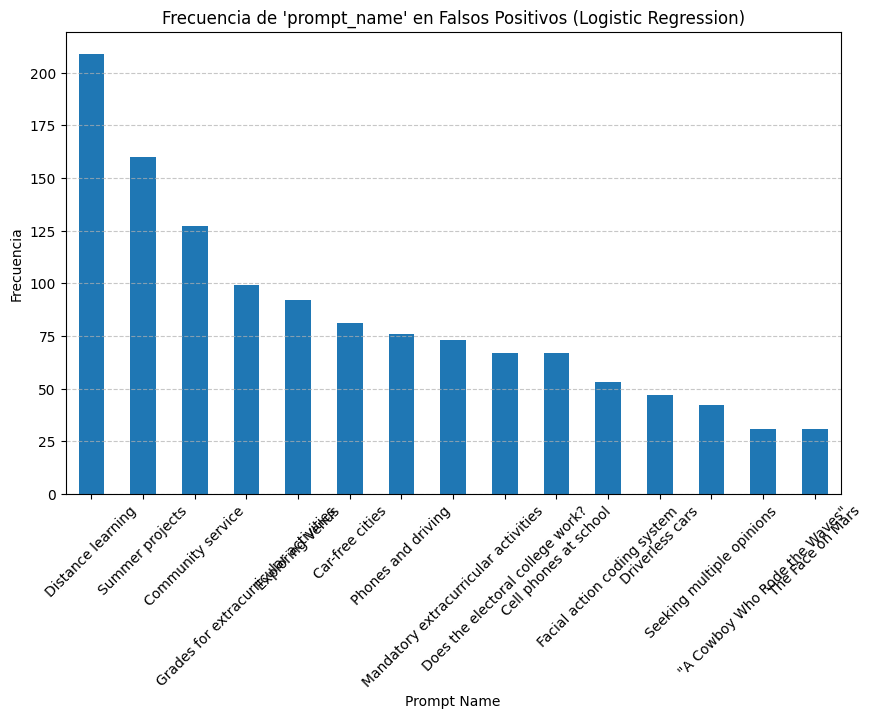


Análisis de Falsos Positivos: XGBoost
Frecuencia de 'source':
source
persuade_corpus    1965
train_essays         73
Name: count, dtype: int64

Frecuencia de 'prompt_name':
prompt_name
Community service                        262
Cell phones at school                    215
Grades for extracurricular activities    209
Distance learning                        208
Summer projects                          189
Does the electoral college work?         128
Mandatory extracurricular activities     126
Car-free cities                          116
Phones and driving                       104
The Face on Mars                          99
Seeking multiple opinions                 86
Exploring Venus                           82
"A Cowboy Who Rode the Waves"             81
Driverless cars                           76
Facial action coding system               57
Name: count, dtype: int64


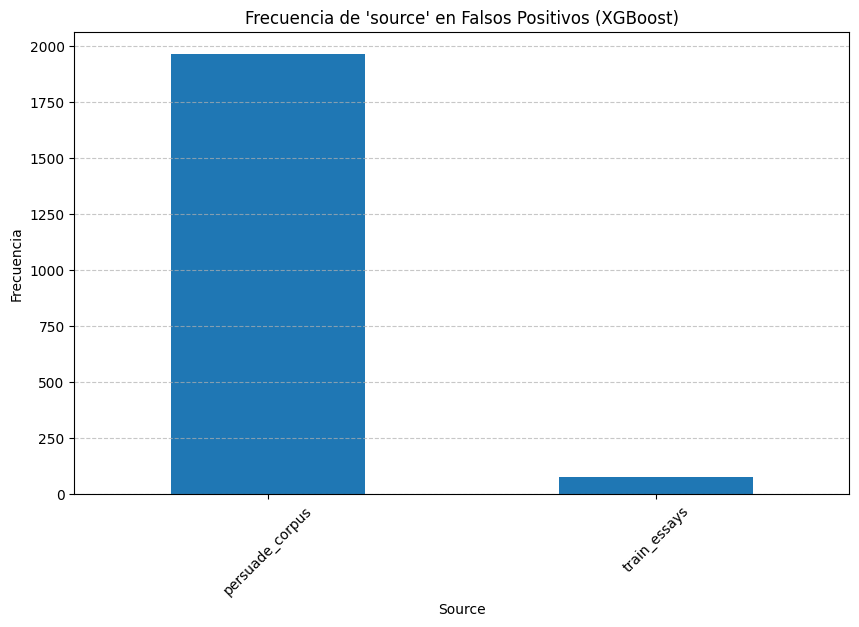

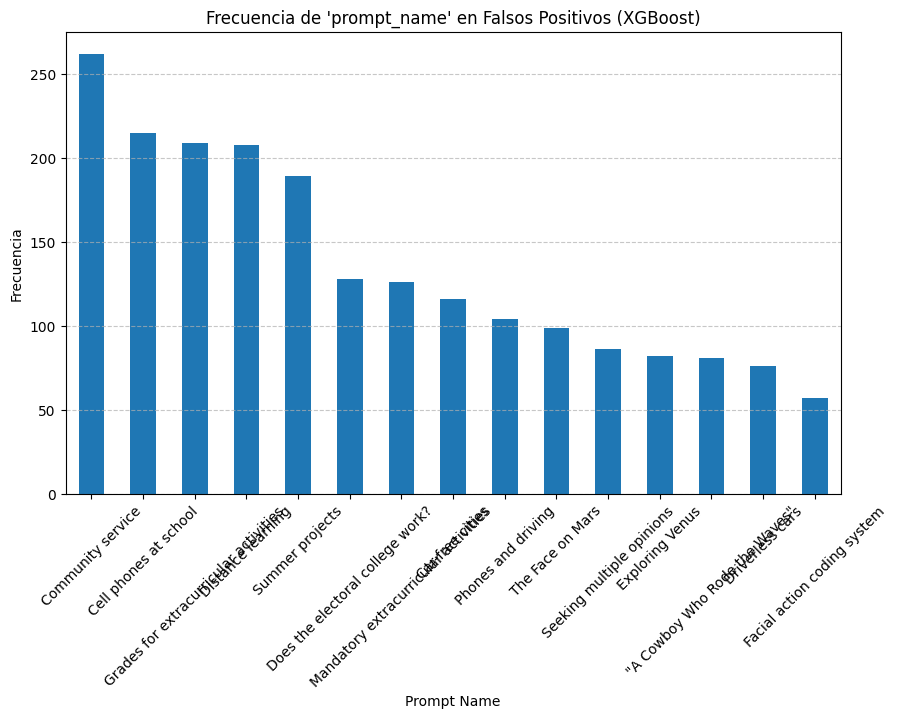


Análisis de Falsos Positivos: LightGBM
Frecuencia de 'source':
source
persuade_corpus    1462
train_essays         42
Name: count, dtype: int64

Frecuencia de 'prompt_name':
prompt_name
Community service                        208
Distance learning                        178
Grades for extracurricular activities    157
Summer projects                          147
Cell phones at school                    135
Mandatory extracurricular activities      96
Does the electoral college work?          85
Exploring Venus                           82
Phones and driving                        72
Car-free cities                           72
"A Cowboy Who Rode the Waves"             64
Seeking multiple opinions                 64
The Face on Mars                          58
Driverless cars                           49
Facial action coding system               37
Name: count, dtype: int64


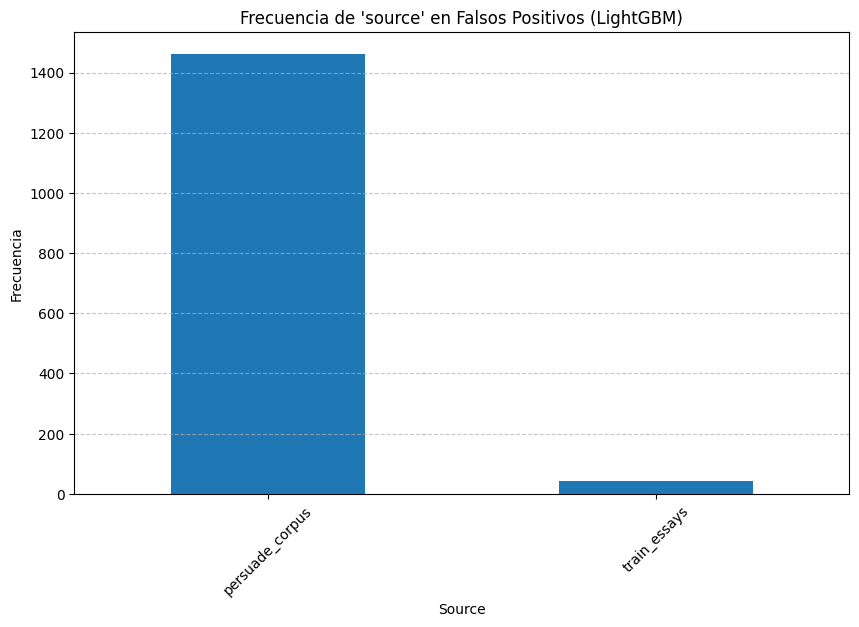

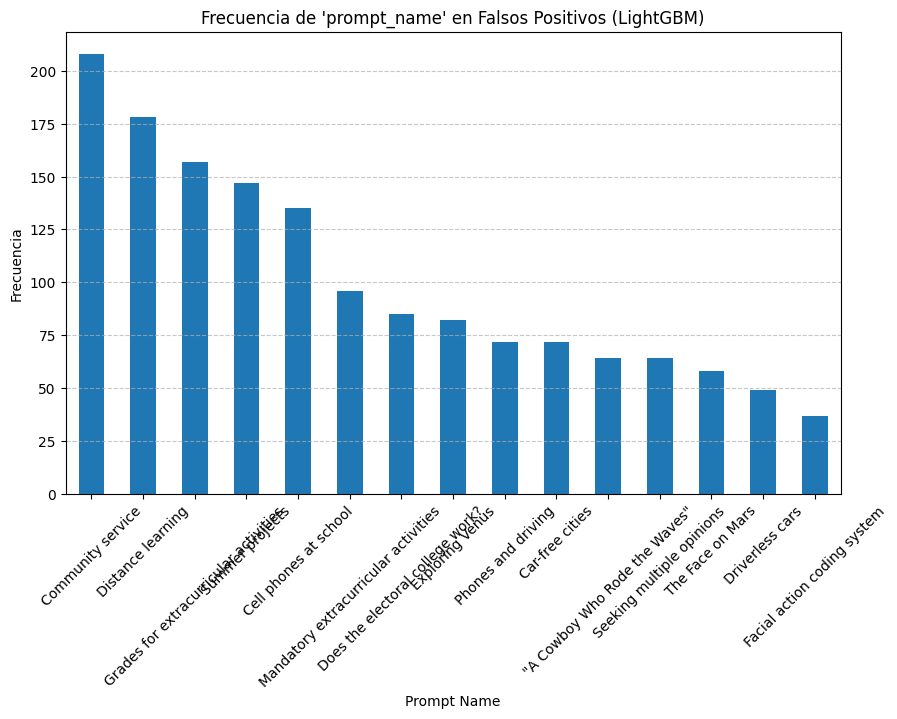


Análisis de Falsos Positivos: Neural Network
Frecuencia de 'source':
source
persuade_corpus    648
train_essays        32
Name: count, dtype: int64

Frecuencia de 'prompt_name':
prompt_name
Distance learning                        125
Summer projects                          109
Mandatory extracurricular activities      66
Community service                         63
Does the electoral college work?          43
Seeking multiple opinions                 43
Car-free cities                           42
Grades for extracurricular activities     42
Cell phones at school                     33
Phones and driving                        31
Exploring Venus                           30
Driverless cars                           16
Facial action coding system               15
"A Cowboy Who Rode the Waves"             14
The Face on Mars                           8
Name: count, dtype: int64


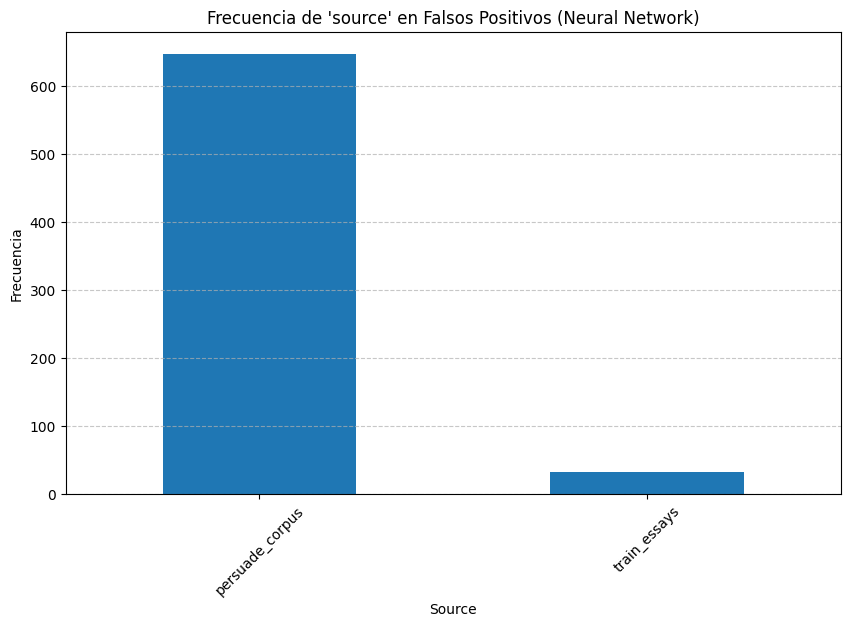

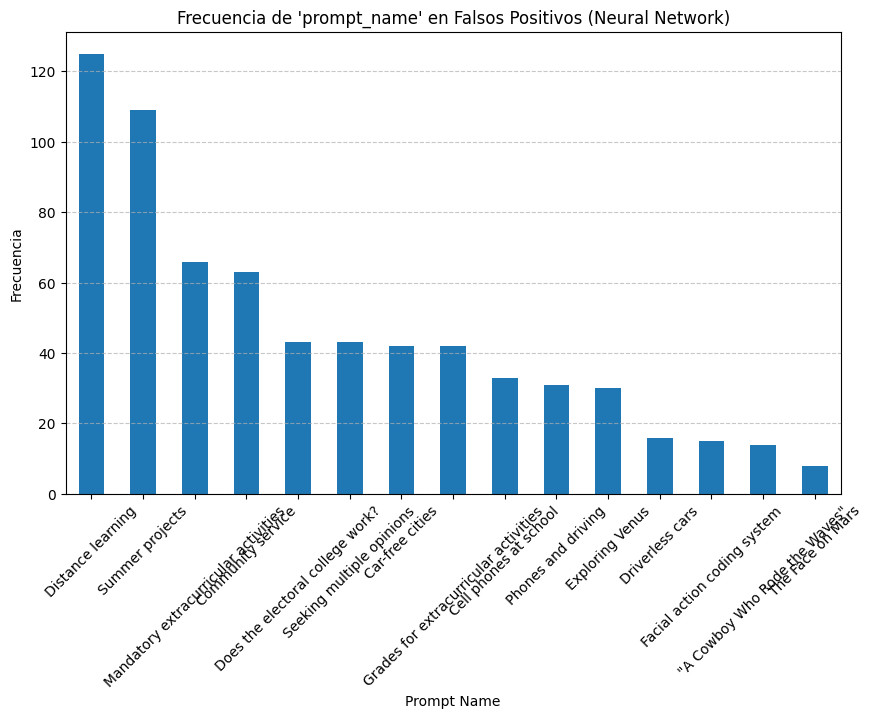

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Función para analizar los falsos positivos
def analyze_false_positives(y_true, y_pred, data, model_name):
    """
    Analiza los falsos positivos en el dataset.
    Args:
        y_true (array): Etiquetas verdaderas.
        y_pred (array): Predicciones del modelo.
        data (DataFrame): Dataset original.
        model_name (str): Nombre del modelo.
    """
    # Identificar índices de falsos positivos
    false_positive_indices = (y_true == 0) & (y_pred == 1)

    # Filtrar los falsos positivos del dataset
    false_positives = data[false_positive_indices]

    # Contar frecuencia de 'source' y 'prompt_name'
    source_counts = false_positives['source'].value_counts()
    prompt_counts = false_positives['prompt_name'].value_counts()

    # Mostrar resultados en texto
    print(f"\nAnálisis de Falsos Positivos: {model_name}")
    print("Frecuencia de 'source':")
    print(source_counts)
    print("\nFrecuencia de 'prompt_name':")
    print(prompt_counts)

    # Visualizar frecuencia de 'source'
    source_counts.plot(kind='bar', title=f"Frecuencia de 'source' en Falsos Positivos ({model_name})", figsize=(10, 6))
    plt.xlabel('Source')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Visualizar frecuencia de 'prompt_name'
    prompt_counts.plot(kind='bar', title=f"Frecuencia de 'prompt_name' en Falsos Positivos ({model_name})", figsize=(10, 6))
    plt.xlabel('Prompt Name')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Análisis para cada modelo
analyze_false_positives(y_true, logistic_preds, data_validation, "Logistic Regression")
analyze_false_positives(y_true, xgboost_preds_binary, data_validation, "XGBoost")
analyze_false_positives(y_true, lightgbm_preds_binary, data_validation, "LightGBM")
analyze_false_positives(y_true, neural_preds, data_validation, "Neural Network")


In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Función para evaluar diferentes umbrales
def evaluate_thresholds(y_true, probs, thresholds, model_name):
    """
    Evalúa diferentes umbrales y muestra métricas clave para cada uno.
    Args:
        y_true (array): Etiquetas verdaderas.
        probs (array): Probabilidades predichas.
        thresholds (list): Lista de umbrales a evaluar.
        model_name (str): Nombre del modelo.
    Returns:
        DataFrame con los resultados.
    """
    print(f"\nEvaluación de Umbrales para {model_name}")
    results = []
    auc = roc_auc_score(y_true, probs)  # Calcular AUC una sola vez

    for threshold in thresholds:
        # Generar predicciones binarias según el umbral
        preds = (probs >= threshold).astype(int)

        # Calcular métricas
        precision = precision_score(y_true, preds, zero_division=0)
        recall = recall_score(y_true, preds, zero_division=0)
        f1 = f1_score(y_true, preds, zero_division=0)

        results.append({
            "Threshold": threshold,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "AUC": auc  # AUC es constante
        })

    # Mostrar resultados como DataFrame
    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

# Lista de umbrales a evaluar
thresholds = np.linspace(0.1, 0.9, 9)

# Evaluar Logistic Regression
logistic_results = evaluate_thresholds(y_true, logistic_probs, thresholds, "Logistic Regression")

# Evaluar XGBoost
xgboost_results = evaluate_thresholds(y_true, xgboost_probs, thresholds, "XGBoost")

# Evaluar LightGBM
lightgbm_results = evaluate_thresholds(y_true, lightgbm_probs, thresholds, "LightGBM")

# Evaluar Neural Network
neural_results = evaluate_thresholds(y_true, neural_probs, thresholds, "Neural Network")

# Guardar resultados en un archivo CSV para análisis posterior
logistic_results.to_csv("logistic_results.csv", index=False)
xgboost_results.to_csv("xgboost_results.csv", index=False)
lightgbm_results.to_csv("lightgbm_results.csv", index=False)
neural_results.to_csv("neural_results.csv", index=False)




Evaluación de Umbrales para Logistic Regression
   Threshold  Precision    Recall  F1-Score       AUC
0        0.1   0.860601  0.993599  0.922330  0.995534
1        0.2   0.890393  0.992627  0.938735  0.995534
2        0.3   0.908891  0.992056  0.948654  0.995534
3        0.4   0.921752  0.991027  0.955135  0.995534
4        0.5   0.932432  0.989827  0.960273  0.995534
5        0.6   0.941314  0.989141  0.964635  0.995534
6        0.7   0.950410  0.987998  0.968839  0.995534
7        0.8   0.960365  0.985998  0.973013  0.995534
8        0.9   0.972734  0.980740  0.976720  0.995534

Evaluación de Umbrales para XGBoost
   Threshold  Precision    Recall  F1-Score       AUC
0        0.1   0.389966  1.000000  0.561116  0.973387
1        0.2   0.744557  0.992856  0.850964  0.973387
2        0.3   0.862884  0.986569  0.920591  0.973387
3        0.4   0.888813  0.966737  0.926139  0.973387
4        0.5   0.891607  0.958107  0.923662  0.973387
5        0.6   0.892834  0.955650  0.923175  0.973

In [11]:
# Añadir probabilidades predichas de cada modelo al dataset original
data_validation['logistic_proba'] = logistic_probs
data_validation['xgboost_proba'] = xgboost_probs
data_validation['lightgbm_proba'] = lightgbm_probs
data_validation['neural_proba'] = neural_probs

# Guardar el dataset enriquecido con las probabilidades
data_validation.to_csv("data_validation_with_probas.csv", index=False)

print("Dataset enriquecido con las probabilidades de cada modelo.")


Dataset enriquecido con las probabilidades de cada modelo.


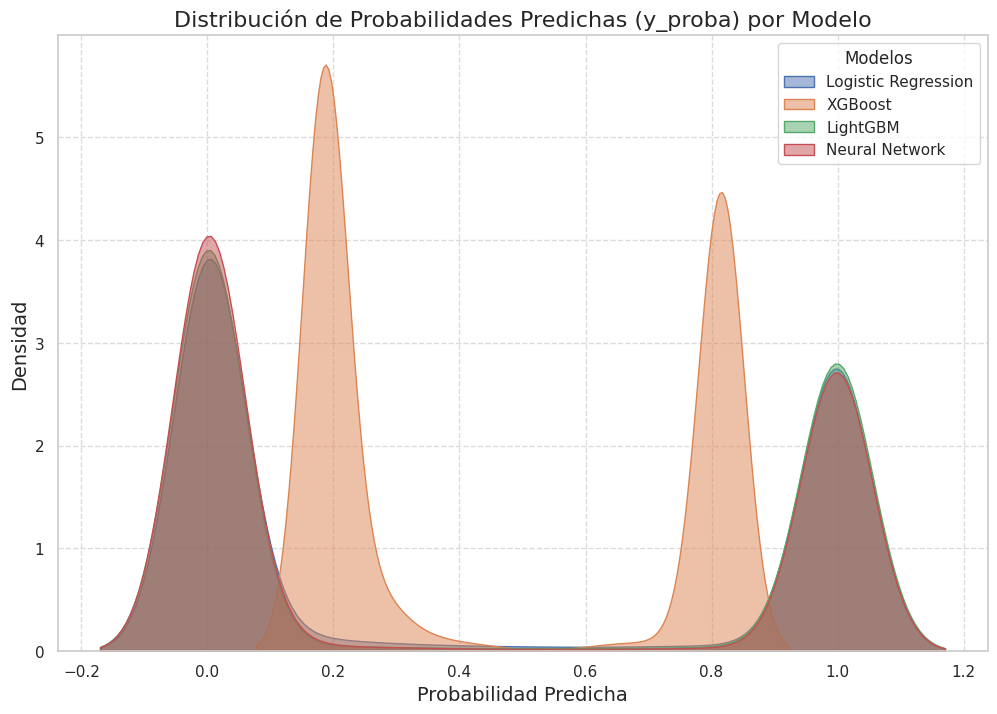

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Lista de modelos y sus probabilidades
models = {
    "Logistic Regression": data_validation['logistic_proba'],
    "XGBoost": data_validation['xgboost_proba'],
    "LightGBM": data_validation['lightgbm_proba'],
    "Neural Network": data_validation['neural_proba']
}

# Crear un gráfico para cada modelo
plt.figure(figsize=(12, 8))
for model_name, probs in models.items():
    sns.kdeplot(probs, label=model_name, fill=True, alpha=0.5)

# Añadir título y etiquetas
plt.title("Distribución de Probabilidades Predichas (y_proba) por Modelo", fontsize=16)
plt.xlabel("Probabilidad Predicha", fontsize=14)
plt.ylabel("Densidad", fontsize=14)
plt.legend(title="Modelos")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [13]:
# Función para discretizar probabilidades usando percentiles y manejar duplicados
def discretize_proba_percentiles(probs, num_categories=7):
    """
    Discretiza las probabilidades en categorías numéricas basadas en percentiles, manejando duplicados.
    Args:
        probs (array): Probabilidades continuas a discretizar.
        num_categories (int): Número de categorías (por defecto 7).
    Returns:
        array: Categorías discretizadas.
    """
    # Calcular los percentiles y manejar duplicados
    bins = np.percentile(probs, np.linspace(0, 100, num_categories + 1), interpolation='midpoint')
    unique_bins = np.unique(bins)  # Eliminar duplicados

    # Verificar que el número de categorías no sea menor al esperado
    if len(unique_bins) - 1 < num_categories:
        print(f"Advertencia: Menos categorías únicas ({len(unique_bins) - 1}) que las esperadas ({num_categories}).")

    # Discretizar las probabilidades
    return pd.cut(probs, bins=unique_bins, labels=range(1, len(unique_bins)), include_lowest=True)

# Discretizar las probabilidades para cada modelo usando percentiles
data_validation['logistic_category'] = discretize_proba_percentiles(data_validation['logistic_proba'])
data_validation['xgboost_category'] = discretize_proba_percentiles(data_validation['xgboost_proba'])
data_validation['lightgbm_category'] = discretize_proba_percentiles(data_validation['lightgbm_proba'])
data_validation['neural_category'] = discretize_proba_percentiles(data_validation['neural_proba'])

# Guardar el dataset con las categorías discretizadas
data_validation.to_csv("/content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/data_validation_with_percentile_categories.csv", index=False)

print("Probabilidades discretizadas en categorías usando percentiles y agregadas al dataset.")



<ipython-input-13-072f20966c84>:23: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  data_validation['logistic_category'] = discretize_proba_percentiles(data_validation['logistic_proba'])
<ipython-input-13-072f20966c84>:24: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  data_validation['xgboost_category'] = discretize_proba_percentiles(data_validation['xgboost_proba'])
<ipython-input-13-072f20966c84>:25: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'mid

Advertencia: Menos categorías únicas (3) que las esperadas (7).
Probabilidades discretizadas en categorías usando percentiles y agregadas al dataset.


Matriz de comparación entre Logistic Regression y XGBoost:
XGBoost                 1     2     3
Logistic Regression                  
1                    6228   182     0
2                    5943   462     5
3                    4898  1433    78
4                    2660  2795   955
5                     182   810  5417
6                       0    45  6365
7                       0     6  6404


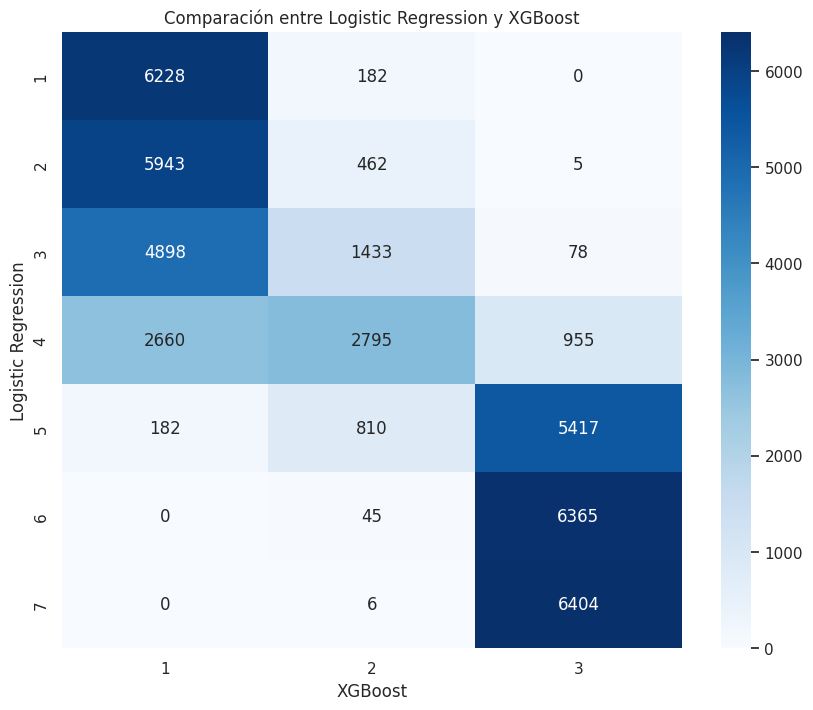

Matriz de comparación entre Logistic Regression y LightGBM:
LightGBM                1     2     3     4     5     6     7
Logistic Regression                                          
1                    3868  1867   637    38     0     0     0
2                    1935  2318  1844   313     0     0     0
3                     571  1825  2538  1456    19     0     0
4                      39   397  1379  3984   610     1     0
5                       0     0    11   618  3687  1589   504
6                       0     0     0     1  1249  2809  2351
7                       0     0     0     0   844  2011  3555


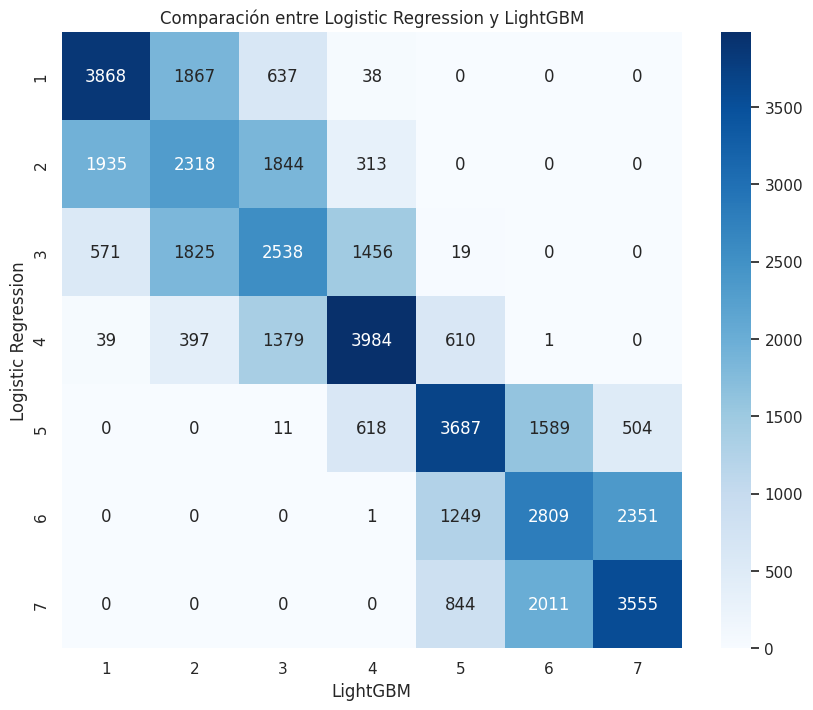

Matriz de comparación entre Logistic Regression y Neural Network:
Neural Network          1     2     3     4     5     6     7
Logistic Regression                                          
1                    5602   804     4     0     0     0     0
2                     784  4407  1198    21     0     0     0
3                      24  1161  4125  1099     0     0     0
4                       0    38  1081  4871   420     0     0
5                       0     0     1   419  4860  1080    49
6                       0     0     0     0  1025  3952  1433
7                       0     0     0     0   106  1377  4927


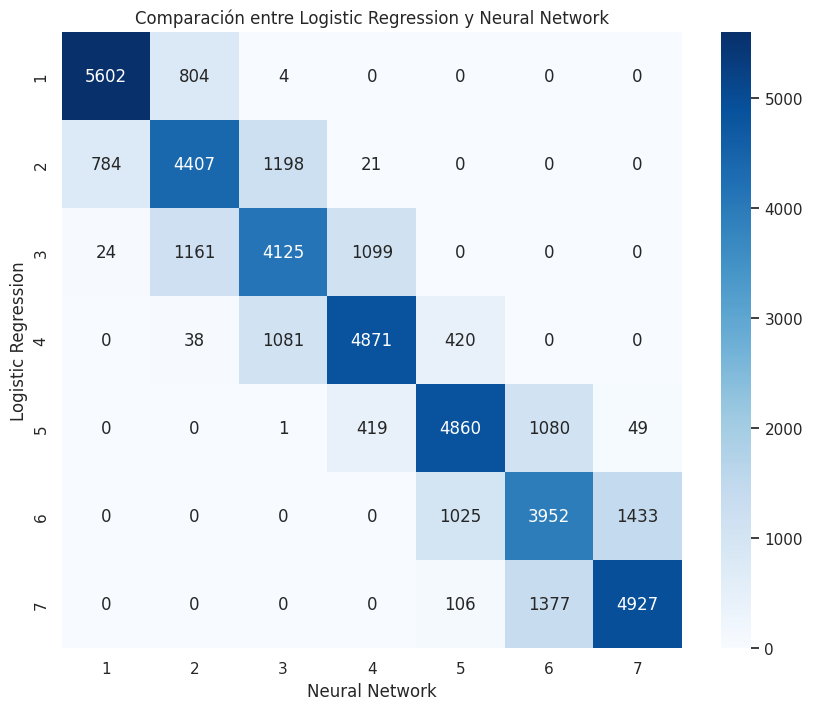

Matriz de comparación entre XGBoost y LightGBM:
LightGBM     1     2     3     4     5     6     7
XGBoost                                           
1         6370  6115  5132  2277    17     0     0
2           43   292  1274  3519   604     1     0
3            0     0     3   614  5788  6409  6410


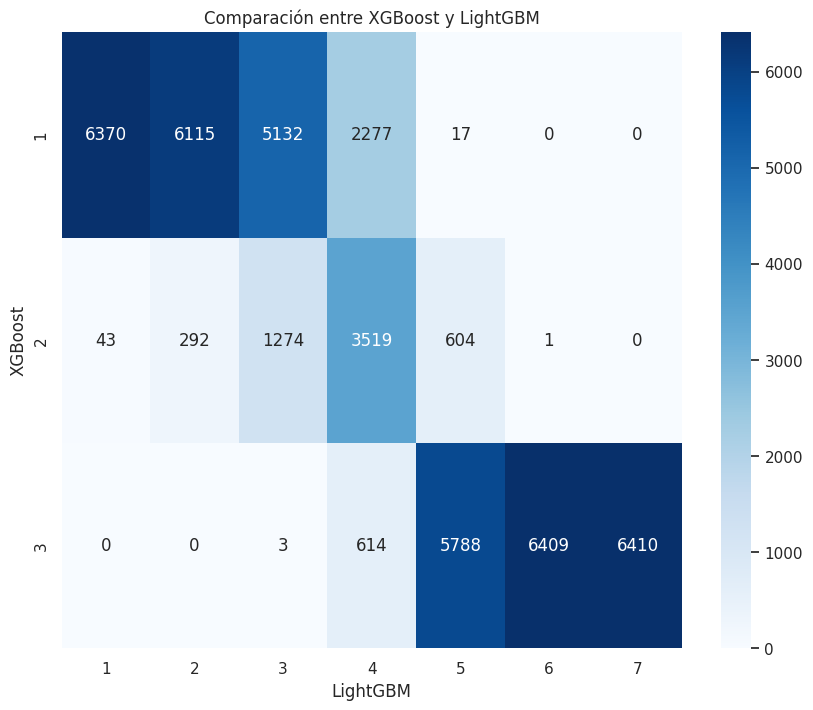

Matriz de comparación entre XGBoost y Neural Network:
Neural Network     1     2     3     4     5     6     7
XGBoost                                                 
1               6189  5835  5088  2671   128     0     0
2                221   572  1286  2841   755    42    16
3                  0     3    35   898  5528  6367  6393


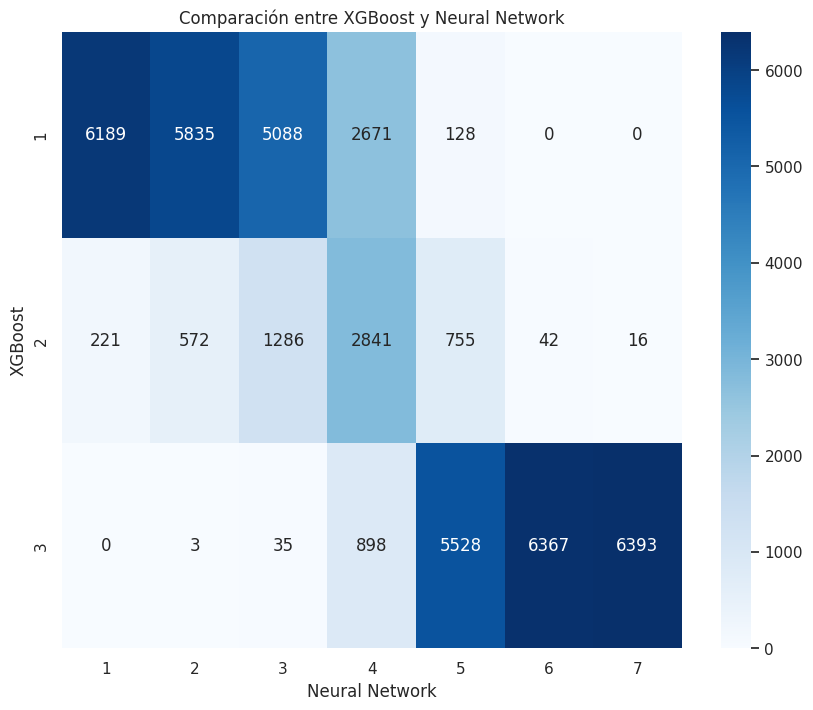

Matriz de comparación entre LightGBM y Neural Network:
Neural Network     1     2     3     4     5     6     7
LightGBM                                                
1               3902  1892   598    21     0     0     0
2               1823  2327  1942   315     0     0     0
3                653  1855  2537  1364     0     0     0
4                 32   336  1326  4211   504     1     0
5                  0     0     6   499  3373  1264  1267
6                  0     0     0     0  1655  2480  2275
7                  0     0     0     0   879  2664  2867


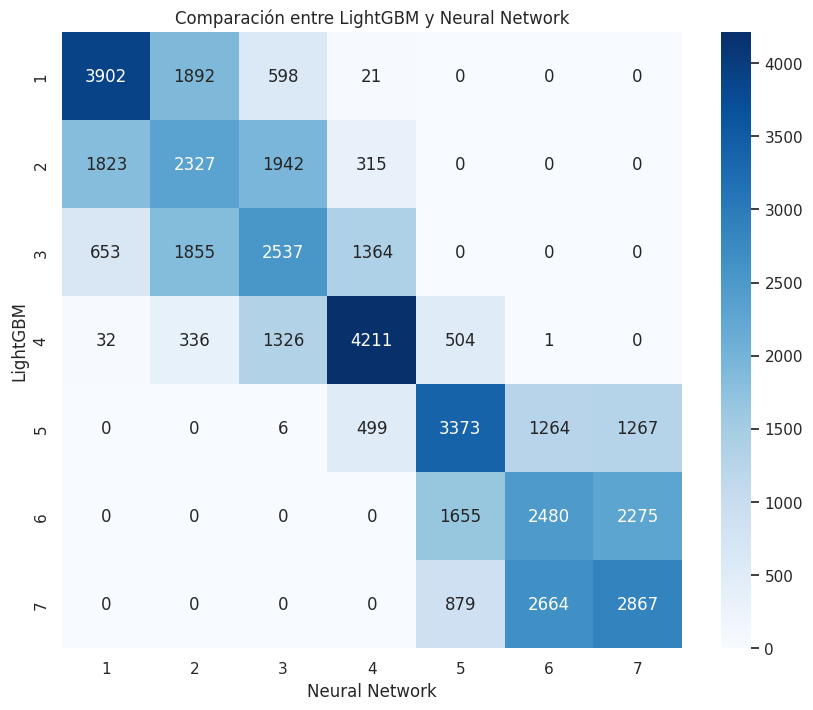

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Lista de nombres de columnas de categorías discretizadas
model_categories = ['logistic_category', 'xgboost_category', 'lightgbm_category', 'neural_category']
model_names = {
    'logistic_category': 'Logistic Regression',
    'xgboost_category': 'XGBoost',
    'lightgbm_category': 'LightGBM',
    'neural_category': 'Neural Network'
}

# Crear tablas cruzadas y gráficos de calor para cada combinación de modelos
for model1, model2 in combinations(model_categories, 2):
    # Crear la tabla cruzada
    comparison_matrix = pd.crosstab(
        data_validation[model1],
        data_validation[model2],
        rownames=[model_names[model1]],
        colnames=[model_names[model2]]
    )

    # Mostrar la tabla cruzada
    print(f"Matriz de comparación entre {model_names[model1]} y {model_names[model2]}:")
    print(comparison_matrix)

    # Visualizar la tabla cruzada como un gráfico de calor
    plt.figure(figsize=(10, 8))
    sns.heatmap(comparison_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f"Comparación entre {model_names[model1]} y {model_names[model2]}")
    plt.xlabel(model_names[model2])
    plt.ylabel(model_names[model1])
    plt.show()


In [15]:
data_validation.head()

,text,label,prompt_name,source,RDizzl3_seven,text_clean_specials_removed,text_clean_keep_specials,tokens_specials_removed,tokens_keep_specials,logistic_proba,xgboost_proba,lightgbm_proba,neural_proba,logistic_category,xgboost_category,lightgbm_category,neural_category
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,phones modern humans today are always on their...,phones modern humans today are always on their...,"['▁phones', '▁modern', '▁humans', '▁today', '▁...","['▁phones', '▁modern', '▁humans', '▁today', '▁...",3.201974e-13,0.184029,0.000020,2.727000e-08,1,1,1,1
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,this essay will explain if drivers should or s...,this essay will explain if drivers should or s...,"['▁this', '▁essay', '▁will', '▁explain', '▁if'...","['▁this', '▁essay', '▁will', '▁explain', '▁if'...",1.104920e-06,0.184029,0.000022,1.805897e-05,2,1,1,2
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,driving while the use of cellular devices toda...,driving while the use of cellular devices toda...,"['▁driving', '▁while', '▁the', '▁use', '▁of', ...","['▁driving', '▁while', '▁the', '▁use', '▁of', ...",2.617213e-03,0.267134,0.000596,5.921831e-05,4,2,4,2
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,phones driving drivers should not be able to u...,phones & driving drivers should not be able to...,"['▁phones', '▁driving', '▁drivers', '▁should',...","['▁phones', '▁&', '▁driving', '▁drivers', '▁sh...",9.955392e-05,0.184029,0.000037,4.527471e-06,3,1,2,1
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,cell phone operation while driving the ability...,cell phone operation while driving the ability...,"['▁cell', '▁phone', '▁operation', '▁while', '▁...","['▁cell', '▁phone', '▁operation', '▁while', '▁...",5.442448e-02,0.199402,0.004232,1.632993e-02,4,2,4,4


In [16]:
from sklearn.manifold import TSNE
import pandas as pd

# Asegurarse de que los embeddings estén en la CPU y en formato numpy
embeddings_cpu = embeddings_keep_specials.cpu().numpy()

# Aplicar t-SNE
print("Aplicando t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, learning_rate='auto')
tsne_results = tsne.fit_transform(embeddings_cpu)

# Crear un DataFrame con los resultados de t-SNE
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE_1', 'TSNE_2'])

# Agregar las dimensiones de t-SNE al dataset original
data_validation['TSNE_1'] = tsne_df['TSNE_1']
data_validation['TSNE_2'] = tsne_df['TSNE_2']

Aplicando t-SNE...


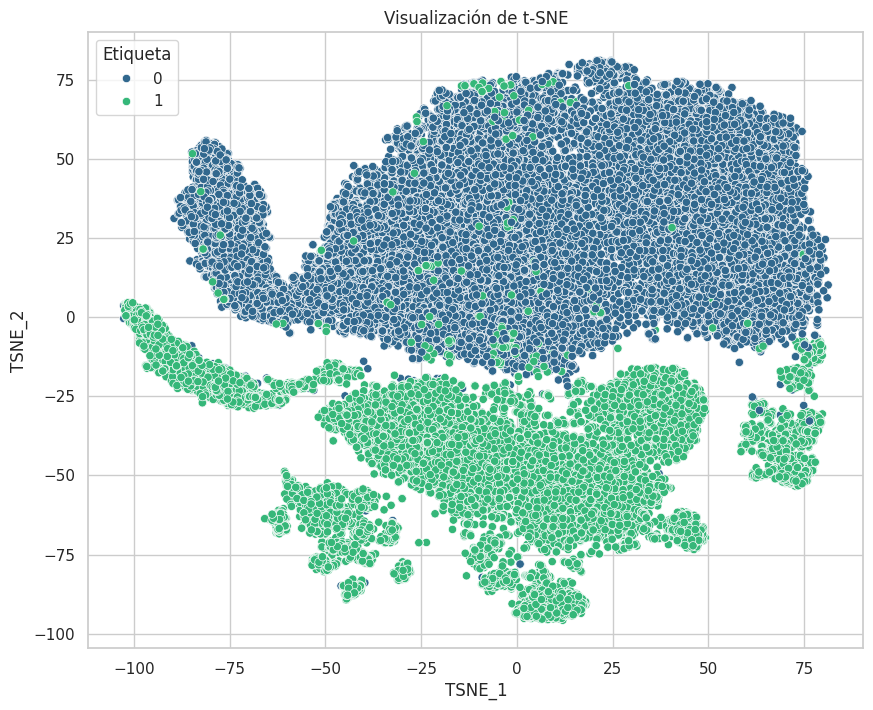

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar los resultados de t-SNE coloreados por la etiqueta real
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue=data_validation['label'], palette='viridis', data=data_validation)
plt.title("Visualización de t-SNE")
plt.xlabel("TSNE_1")
plt.ylabel("TSNE_2")
plt.legend(title='Etiqueta')
plt.grid(True)
plt.show()


In [18]:
import pandas as pd

# Asegurarse de que los embeddings están en CPU y en formato NumPy
embeddings_cpu = embeddings_keep_specials.cpu().numpy()

# Crear un DataFrame de los embeddings e incluir la columna 'label'
embeddings_df = pd.DataFrame(embeddings_cpu)
embeddings_df['label'] = data_validation['label'].values  # Asegura que las etiquetas coincidan

# Crear columna 'id' para relacionar ambos datasets
data_validation['id'] = data_validation.index
embeddings_df['id'] = embeddings_df.index

# Reorganizar las columnas (opcional)
embeddings_df = embeddings_df[['id', 'label'] + [col for col in embeddings_df.columns if col not in ['id', 'label']]]

# Exportar el dataset de validación con separador ';' y decimal ','
data_validation.to_csv(
    "/content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/data_validation_with_percentile_categories_es.csv",
    sep=';',      # Separador de columnas: punto y coma
    decimal=',',  # Separador decimal: coma
    index=False
)

# Exportar el dataset de embeddings con separador ';' y decimal ','
embeddings_df.to_csv(
    "/content/drive/MyDrive/TFM_Kschool/DataSets/Dmitiva/data6k/DeBerta_train/embeddings_with_labels_es.csv",
    sep=';',      # Separador de columnas: punto y coma
    decimal=',',  # Separador decimal: coma
    index=False
)

print("Ambos datasets han sido guardados correctamente con el formato adecuado para Power BI.")



Ambos datasets han sido guardados correctamente con el formato adecuado para Power BI.
